# Part I. RUL prediction using Transformer model (Centralize model)

# Preparation

In [1]:
# When run code on Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
print(f'IN_COLAB: {IN_COLAB}')

IN_COLAB: False


In [2]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [3]:
# Off log duplicate messages
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

# Off warning messages
import warnings
warnings.filterwarnings('ignore')

if not IN_COLAB:
    try:
        import pyinspect as pi
    except:
        pass

In [4]:
from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from datasets.utils.logging import disable_progress_bar

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

import shap

e:\IAD\.venv\Lib\site-packages\shap\plots\colors\_colorconv.py:819: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if np.issubdtype(dtype_in, np.dtype(dtype).type):


In [5]:
# Check GPU if available else CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.13.1 / PyTorch 2.5.1+cpu


# Building Transformer model

In [6]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])
        return output.squeeze(-1)

# Building Dataloader

In [7]:
class CMAPSSLoaderDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3','Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):

        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )

# Define parameters for training

In [8]:
# Transformer parameters
input_dim = 21
d_model = 64
nhead = 4
num_layers = 2
dim_feedforward = 256
dropout = 0.1
learning_rate = 1e-3
verbose=False

# Dataloader parameters
sequence_length = 30

# Training parameters
batch_size = 128
epochs = 50

# Define training/test functions

In [9]:
def train_model(model, client_loader_train, client_loader_validation: None, epochs: int, learning_rate: int, verbose=False):
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(client_loader_train)}, Validation Loss: {val_loss/len(client_loader_validation)}")

In [10]:
def test_model(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for batch in client_loader_validation:
            samples, targets = batch
            samples, targets = samples.to(DEVICE), targets.to(DEVICE)
            predictions = model(samples)
            val_loss += criterion(predictions, targets).item()
    return val_loss/len(client_loader_validation)

# Define prediction functions

### Prediction on a batch

In [11]:
def predict_on_batch(model, batch_loader, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    samples, targets = batch_loader
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    model.eval()
    loss = 0
    with torch.no_grad():
        predictions = model(samples)
    loss = criterion(predictions, targets)

    if return_actual_rul:
        samples = samples.cpu()
        targets = targets.cpu()

        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        predictions = predictions.cpu()
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return loss, actual_predictions, actual_targets

    return loss

### Prediction on a sample

# File paths

In [12]:
if not IN_COLAB:
    train_1_path = "../data/train_FD001.txt"
    test_1_path = "../data/test_FD001.txt"
    rul_1_path = "../data/RUL_FD001.txt"

    train_2_path = "../data/train_FD002.txt"
    test_2_path = "../data/test_FD002.txt"
    rul_2_path = "../data/RUL_FD002.txt"

    train_3_path = "../data/train_FD003.txt"
    test_3_path = "../data/test_FD003.txt"
    rul_3_path = "../data/RUL_FD003.txt"

    train_4_path = "../data/train_FD004.txt"
    test_4_path = "../data/test_FD004.txt"
    rul_4_path = "../data/RUL_FD004.txt"
    
elif IN_COLAB:
    train_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD001.txt"
    test_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD001.txt"
    rul_1_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD001.txt"

    train_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD002.txt"
    test_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD002.txt"
    rul_2_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD002.txt"

    train_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD003.txt"
    test_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD003.txt"
    rul_3_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD003.txt"

    train_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD004.txt"
    test_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/test_FD004.txt"
    rul_4_path = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/RUL_FD004.txt"

In [13]:
# Initialization columns
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

# Calculate RUL for FD001

### Calculate RUL for train set

In [14]:
# Load trainset
train_1 = pd.read_csv(train_1_path, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''
# train_1.head()

In [15]:
# Calculate the remaining RUL for each engine
max_cycle_1 = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle_1.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

print(f"trainset shape: {train_1.shape}")

trainset shape: (20631, 27)


In [16]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### Load RUL set

In [17]:
rul_1 = pd.read_csv(rul_1_path, sep=' ', header=None)
rul_1.drop(rul_1.columns[1], axis=1, inplace=True)
rul_1.columns = ['RUL']
print(f'RUL shape: {rul_1.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [18]:
rul_1.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### Calculate RUL for test

In [19]:
# Load test set
test_1 = pd.read_csv(test_1_path, sep=' ', header=None)
test_1.drop([26, 27], axis=1, inplace=True)
test_1.columns = column_names

test_1['Remaining RUL'] = ''
# test_1.head()

In [20]:
max_cycle_test_1 = test_1.groupby('ID Engine').count()

for idx in range(len(test_1)):
    test_1.loc[idx, 'Remaining RUL'] = rul_1.loc[test_1.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_1.loc[test_1.loc[idx, 'ID Engine'], 'Cycle']
test_1['Remaining RUL'] = test_1['Remaining RUL'] - test_1['Cycle']

In [21]:
test_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


# Calculate RUL for FD002

### Calculate RUL for train set

In [22]:
# Load trainset
train_2 = pd.read_csv(train_2_path, sep=' ', header=None)
train_2.drop([26, 27], axis=1, inplace=True)
train_2.columns = column_names

train_2['Remaining RUL'] = ''
# train_2.head()

In [23]:
# Calculate the remaining RUL for each engine
max_cycle_2 = train_2.groupby('ID Engine').count()
for idx in range(len(train_2)):
    train_2.loc[idx, 'Remaining RUL'] = max_cycle_2.loc[train_2.loc[idx, 'ID Engine'], 'Cycle']
train_2['Remaining RUL'] = train_2['Remaining RUL'] - train_2['Cycle']

print(f"trainset shape: {train_2.shape}")

trainset shape: (53759, 27)


In [24]:
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


### Load RUL set

In [25]:
rul_2 = pd.read_csv(rul_2_path, sep=' ', header=None)
rul_2.drop(rul_2.columns[1], axis=1, inplace=True)
rul_2.columns = ['RUL']
print(f'RUL shape: {rul_2.shape}')

RUL shape: (259, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [26]:
rul_2.head()

,RUL
0,18
1,79
2,106
3,110
4,15


### Calculate RUL for test

In [27]:
# Load test set
test_2 = pd.read_csv(test_2_path, sep=' ', header=None)
test_2.drop([26, 27], axis=1, inplace=True)
test_2.columns = column_names

test_2['Remaining RUL'] = ''
# test_2.head()

In [28]:
max_cycle_test_2 = test_2.groupby('ID Engine').count()

for idx in range(len(test_2)):
    test_2.loc[idx, 'Remaining RUL'] = rul_2.loc[test_2.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_2.loc[test_2.loc[idx, 'ID Engine'], 'Cycle']
test_2['Remaining RUL'] = test_2['Remaining RUL'] - test_2['Cycle']

In [29]:
test_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,9.9987,0.2502,100.0,489.05,605.03,1497.17,1304.99,10.52,...,2388.18,8114.10,8.6476,0.03,369,2319,100.00,28.42,17.1551,275
1,1,2,20.0026,0.7000,100.0,491.19,607.82,1481.20,1246.11,9.35,...,2388.12,8053.06,9.2405,0.02,364,2324,100.00,24.29,14.8039,274
2,1,3,35.0045,0.8400,100.0,449.44,556.00,1359.08,1128.36,5.48,...,2387.75,8053.04,9.3472,0.02,333,2223,100.00,14.98,8.9125,273
3,1,4,42.0066,0.8410,100.0,445.00,550.17,1349.69,1127.89,3.91,...,2387.72,8066.90,9.3961,0.02,332,2212,100.00,10.35,6.4181,272
4,1,5,24.9985,0.6213,60.0,462.54,536.72,1253.18,1050.69,7.05,...,2028.05,7865.66,10.8682,0.02,305,1915,84.93,14.31,8.5740,271


# Calculate RUL for FD003

### Calculate RUL for train set

In [30]:
# Load trainset
train_3 = pd.read_csv(train_3_path, sep=' ', header=None)
train_3.drop([26, 27], axis=1, inplace=True)
train_3.columns = column_names

train_3['Remaining RUL'] = ''
# train_3.head()

In [31]:
# Calculate the remaining RUL for each engine
max_cycle_3 = train_3.groupby('ID Engine').count()
for idx in range(len(train_3)):
    train_3.loc[idx, 'Remaining RUL'] = max_cycle_3.loc[train_3.loc[idx, 'ID Engine'], 'Cycle']
train_3['Remaining RUL'] = train_3['Remaining RUL'] - train_3['Cycle']

print(f"trainset shape: {train_3.shape}")

trainset shape: (24720, 27)


In [32]:
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


### Load RUL set

In [33]:
rul_3 = pd.read_csv(rul_3_path, sep=' ', header=None)
rul_3.drop(rul_3.columns[1], axis=1, inplace=True)
rul_3.columns = ['RUL']
print(f'RUL shape: {rul_3.shape}')

RUL shape: (100, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [34]:
rul_3.head()

,RUL
0,44
1,51
2,27
3,120
4,101


### Calculate RUL for test

In [35]:
# Load test set
test_3 = pd.read_csv(test_3_path, sep=' ', header=None)
test_3.drop([26, 27], axis=1, inplace=True)
test_3.columns = column_names

test_3['Remaining RUL'] = ''
# test_3.head()

In [36]:
max_cycle_test_3 = test_3.groupby('ID Engine').count()

for idx in range(len(test_3)):
    test_3.loc[idx, 'Remaining RUL'] = rul_3.loc[test_3.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_3.loc[test_3.loc[idx, 'ID Engine'], 'Cycle']
test_3['Remaining RUL'] = test_3['Remaining RUL'] - test_3['Cycle']

In [37]:
test_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,2387.94,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,276
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,2388.01,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,275
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,2387.94,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,274
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,2387.96,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,273
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,2387.97,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,272


# Calculate RUL for FD004

### Calculate RUL for train set

In [38]:
# Load trainset
train_4 = pd.read_csv(train_4_path, sep=' ', header=None)
train_4.drop([26, 27], axis=1, inplace=True)
train_4.columns = column_names

train_4['Remaining RUL'] = ''
# train_4.head()

In [39]:
# Calculate the remaining RUL for each engine
max_cycle_4 = train_4.groupby('ID Engine').count()
for idx in range(len(train_4)):
    train_4.loc[idx, 'Remaining RUL'] = max_cycle_4.loc[train_4.loc[idx, 'ID Engine'], 'Cycle']
train_4['Remaining RUL'] = train_4['Remaining RUL'] - train_4['Cycle']

print(f"trainset shape: {train_4.shape}")

trainset shape: (61249, 27)


In [40]:
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


### Load RUL set

In [41]:
rul_4 = pd.read_csv(rul_4_path, sep=' ', header=None)
rul_4.drop(rul_4.columns[1], axis=1, inplace=True)
rul_4.columns = ['RUL']
print(f'RUL shape: {rul_4.shape}')

RUL shape: (248, 1)


Tập RUL này là vòng đời còn lại của động cơ sau khi trải qua số lượng chu kỳ nhất định trong tập test (tương ứng)

In [42]:
rul_4.head()

,RUL
0,22
1,39
2,107
3,75
4,149


### Calculate RUL for test

In [43]:
# Load test set
test_4 = pd.read_csv(test_4_path, sep=' ', header=None)
test_4.drop([26, 27], axis=1, inplace=True)
test_4.columns = column_names

test_4['Remaining RUL'] = ''
# test_4.head()

In [44]:
max_cycle_test_4 = test_4.groupby('ID Engine').count()

for idx in range(len(test_4)):
    test_4.loc[idx, 'Remaining RUL'] = rul_4.loc[test_4.loc[idx, 'ID Engine'] - 1, 'RUL'] + max_cycle_test_4.loc[test_4.loc[idx, 'ID Engine'], 'Cycle']
test_4['Remaining RUL'] = test_4['Remaining RUL'] - test_4['Cycle']

In [45]:
test_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,2387.78,8048.98,9.2229,0.02,362,2324,100.00,24.31,14.7007,251
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,2028.09,7863.46,10.8632,0.02,306,1915,84.93,14.36,8.5748,250
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,2387.95,8071.13,9.3960,0.02,328,2212,100.00,10.39,6.4365,249
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,2387.90,8078.89,9.3594,0.02,328,2212,100.00,10.56,6.2367,248
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,2387.87,8057.83,9.3030,0.02,333,2223,100.00,14.85,8.9326,247


# Plot number of sample for each dataset

In [46]:
len(train_1)

20631

In [47]:
len(train_2)

53759

In [48]:
len(train_3)

24720

In [49]:
len(train_4)

61249

In [50]:
total = len(train_1) + len(train_2) + len(train_3) + len(train_4)
total

160359

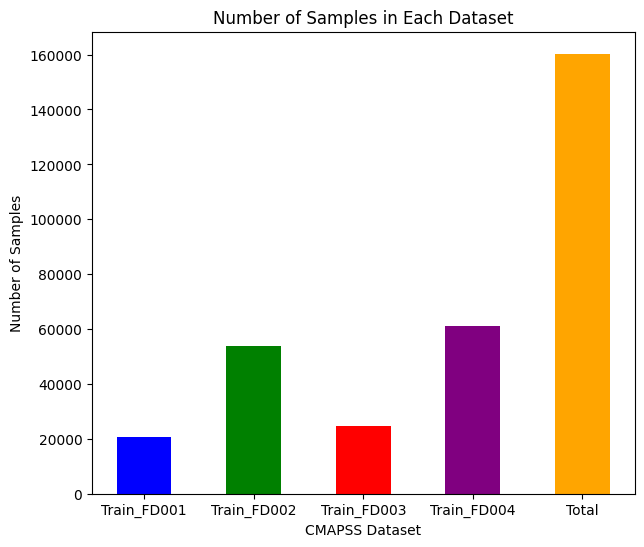

In [51]:
sample_counts = [len(train_1), len(train_2), len(train_3), len(train_4), total]
labels = ['Train_FD001', 'Train_FD002', 'Train_FD003', 'Train_FD004', 'Total']

plt.figure(figsize=(7, 6))
plt.bar(labels, sample_counts, color=['blue', 'green', 'red', 'purple', 'orange'], width=0.5)
plt.xlabel('CMAPSS Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Dataset')
plt.show()

# Concatenate for train_FD001,2,3,4

In [52]:
print(f'train_1 shape: {train_1.shape}')
print(f'test_1 shape: {test_1.shape}')
print(f'rul_1 shape: {rul_1.shape}')
print(f'max_cycle_1 shape: {max_cycle_1.shape}')

train_1 shape: (20631, 27)
test_1 shape: (13096, 27)
rul_1 shape: (100, 1)
max_cycle_1 shape: (100, 26)


In [53]:
print(f'train_2 shape: {train_2.shape}')
print(f'test_2 shape: {test_2.shape}')
print(f'rul_2 shape: {rul_2.shape}')
print(f'max_cycle_2 shape: {max_cycle_2.shape}')

train_2 shape: (53759, 27)
test_2 shape: (33991, 27)
rul_2 shape: (259, 1)
max_cycle_2 shape: (260, 26)


In [54]:
print(f'train_3 shape: {train_3.shape}')
print(f'test_3 shape: {test_3.shape}')
print(f'rul_3 shape: {rul_3.shape}')
print(f'max_cycle_3 shape: {max_cycle_3.shape}')

train_3 shape: (24720, 27)
test_3 shape: (16596, 27)
rul_3 shape: (100, 1)
max_cycle_3 shape: (100, 26)


In [55]:
print(f'train_4 shape: {train_4.shape}')
print(f'test_4 shape: {test_4.shape}')
print(f'rul_4 shape: {rul_4.shape}')
print(f'max_cycle_4 shape: {max_cycle_4.shape}')

train_4 shape: (61249, 27)
test_4 shape: (41214, 27)
rul_4 shape: (248, 1)
max_cycle_4 shape: (249, 26)


In [56]:
train_1.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [57]:
num = len(train_1)
for idx in range(len(train_2)):
    train_2.loc[idx, 'ID Engine'] += num
train_2.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,20632,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,20632,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,20632,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,20632,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,20632,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [58]:
num += len(train_2)
for idx in range(len(train_3)):
    train_3.loc[idx, 'ID Engine'] += num
train_3.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,74391,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,74391,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,74391,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,74391,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,74391,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [59]:
num += len(train_3)
for idx in range(len(train_4)):
    train_4.loc[idx, 'ID Engine'] += num
train_4.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,99111,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,99111,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,99111,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,99111,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,99111,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


In [60]:
train = pd.concat([train_1, train_2, train_3, train_4], ignore_index=True)
print(f'Train shape: {train.shape}')
train.head()

Train shape: (160359, 27)


,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


# Standard data (for train and test set)

In [61]:
scaled_columns = train.columns[5:]
scaler = MinMaxScaler()
train[scaled_columns] = scaler.fit_transform(train[scaled_columns])
# test[scaled_columns] = scaler.fit_transform(test[scaled_columns])

In [62]:
train.head()

,ID Engine,Cycle,Setting 1,Setting 2,Setting 3,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,...,Sensor 13,Sensor 14,Sensor 15,Sensor 16,Sensor 17,Sensor 18,Sensor 19,Sensor 20,Sensor 21,Remaining RUL
0,1,1,-0.0007,-0.0004,100.0,1.0,0.969990,0.927293,0.902111,1.0,...,0.993194,0.653748,0.090428,1.0,0.918367,1.0,1.0,0.972082,0.970373,0.352399
1,1,2,0.0019,-0.0003,100.0,1.0,0.973000,0.932957,0.908192,1.0,...,0.993332,0.637831,0.094654,1.0,0.918367,1.0,1.0,0.970064,0.970630,0.350554
2,1,3,-0.0043,0.0003,100.0,1.0,0.974824,0.922723,0.910730,1.0,...,0.993222,0.641715,0.089844,1.0,0.897959,1.0,1.0,0.968382,0.966204,0.348708
3,1,4,0.0007,0.0000,100.0,1.0,0.974824,0.908829,0.905152,1.0,...,0.993359,0.643055,0.072803,1.0,0.918367,1.0,1.0,0.966028,0.967860,0.346863
4,1,5,-0.0019,-0.0002,100.0,1.0,0.975007,0.908989,0.915565,1.0,...,0.993249,0.642988,0.093829,1.0,0.928571,1.0,1.0,0.966700,0.969560,0.345018


In [63]:
# test.head()

# Training with sequence_length = 1

### Load data into DataLoader

In [64]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=1)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

In [87]:
data_train[1][0]


tensor([[0.0000, 0.1262, 0.2916, 0.2269, 0.0000, 0.0025, 0.0077, 0.6272, 0.2661,
         0.2308, 0.4580, 0.0050, 0.9932, 0.5372, 0.4003, 0.0000, 0.2857, 0.6279,
         1.0000, 0.0195, 0.0202]])

In [85]:
data_train[1][1]

tensor(0.4613)

### Training centralize model

In [65]:
centralize_transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=256,
    dropout=dropout
)

In [66]:
try:
    train_model(
        model=centralize_transformer_model,
        client_loader_train=train_loader,
        client_loader_validation=validation_loader,
        epochs=50,
        # epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )
except KeyboardInterrupt:
    print("Training interrupted")

Epoch 1/50, Train Loss: 0.03212530080949589, Validation Loss: 0.02517296236557552
Epoch 2/50, Train Loss: 0.02374893418538309, Validation Loss: 0.01753500745116002
Epoch 3/50, Train Loss: 0.013320657541624393, Validation Loss: 0.010754531991493654
Epoch 4/50, Train Loss: 0.01157618957503902, Validation Loss: 0.012216425508231044
Epoch 5/50, Train Loss: 0.011314436968356548, Validation Loss: 0.010523472968266305
Epoch 6/50, Train Loss: 0.011150567642397295, Validation Loss: 0.01069914772030545
Epoch 7/50, Train Loss: 0.01119241910890963, Validation Loss: 0.010543482049750499
Epoch 8/50, Train Loss: 0.011030415653837018, Validation Loss: 0.0105712430633278
Epoch 9/50, Train Loss: 0.01088620575445733, Validation Loss: 0.010367920115753356
Epoch 10/50, Train Loss: 0.010951667318375017, Validation Loss: 0.010403170283750233
Epoch 11/50, Train Loss: 0.010840250788756079, Validation Loss: 0.01042255279478205
Epoch 12/50, Train Loss: 0.010865503806966253, Validation Loss: 0.011887675967527576


### Predict on batch

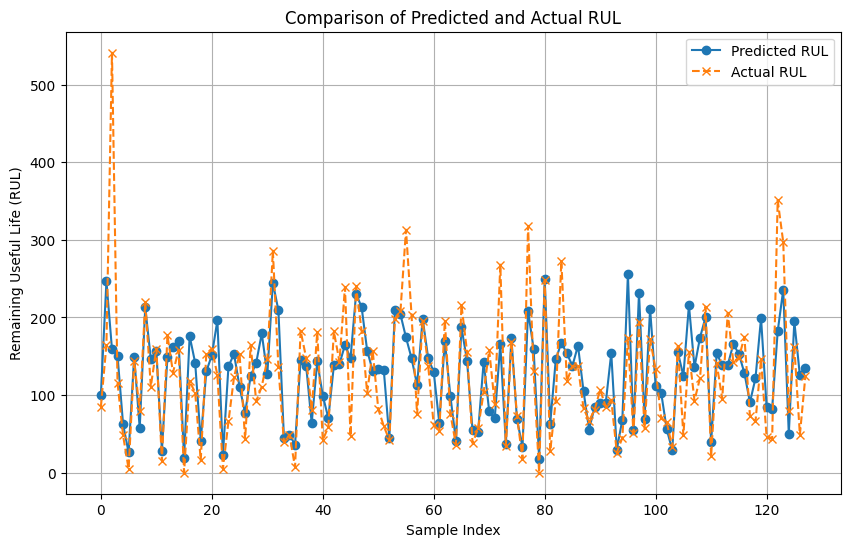

Loss on random batch: 0.01072958204895258


In [70]:
batch_loader = next(iter(validation_loader))

loss, _, _ = predict_on_batch(
    model=centralize_transformer_model,
    batch_loader=batch_loader,
    return_actual_rul=True,
    show_fig=True,
)
print(f'Loss on random batch: {loss}')

# Training with sequence_length = 5

### Load data into DataLoader

In [ ]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=5)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

### Training centralize model

In [ ]:
centralize_transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=256,
    dropout=dropout
)

In [ ]:
try:
    train_model(
        model=centralize_transformer_model,
        client_loader_train=train_loader,
        client_loader_validation=validation_loader,
        epochs=50,
        # epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )
except KeyboardInterrupt:
    print("Training interrupted")

### Predict on batch

In [ ]:
batch_loader = next(iter(validation_loader))

loss, _, _ = predict_on_batch(
    model=centralize_transformer_model,
    batch_loader=batch_loader,
    return_actual_rul=True,
    show_fig=True,
)
print(f'Loss on random batch: {loss}')

# Training with sequence_length = 10

### Load data into DataLoader

In [ ]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=10)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

### Training centralize model

In [ ]:
centralize_transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=256,
    dropout=dropout
)

In [ ]:
try:
    train_model(
        model=centralize_transformer_model,
        client_loader_train=train_loader,
        client_loader_validation=validation_loader,
        epochs=50,
        # epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )
except KeyboardInterrupt:
    print("Training interrupted")

### Predic on batch

In [ ]:
batch_loader = next(iter(validation_loader))

loss, _, _ = predict_on_batch(
    model=centralize_transformer_model,
    batch_loader=batch_loader,
    return_actual_rul=True,
    show_fig=True,
)
print(f'Loss on random batch: {loss}')

# Training with sequence_length = 30

### Load data into DataLoader

In [58]:
data_train = CMAPSSLoaderDataset(data=train, sequence_length=sequence_length)
# data_test = CMAPSSLoaderDataset(data=test, sequence_length=sequence_length)

data_train, data_validation = train_test_split(data_train, test_size=0.2, random_state=42)
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(data_validation, batch_size=batch_size, shuffle=True)

In [59]:
data_train.__len__()

111838

In [60]:
data_validation.__len__()

27960

In [61]:
train_loader.__len__()

874

In [62]:
validation_loader.__len__()

219

### Training centralize model

In [63]:
centralize_transformer_model = TransformerModel(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=256,
    dropout=dropout
)

In [66]:
try:
    train_model(
        model=centralize_transformer_model,
        client_loader_train=train_loader,
        client_loader_validation=validation_loader,
        epochs=1,
        # epochs=epochs,
        learning_rate=learning_rate,
        verbose=False
    )
except KeyboardInterrupt:
    print("Training interrupted")

Epoch 1/1, Train Loss: 0.010377584753059345, Validation Loss: 0.009656188522622873


### Predict on batch (Centralize model)

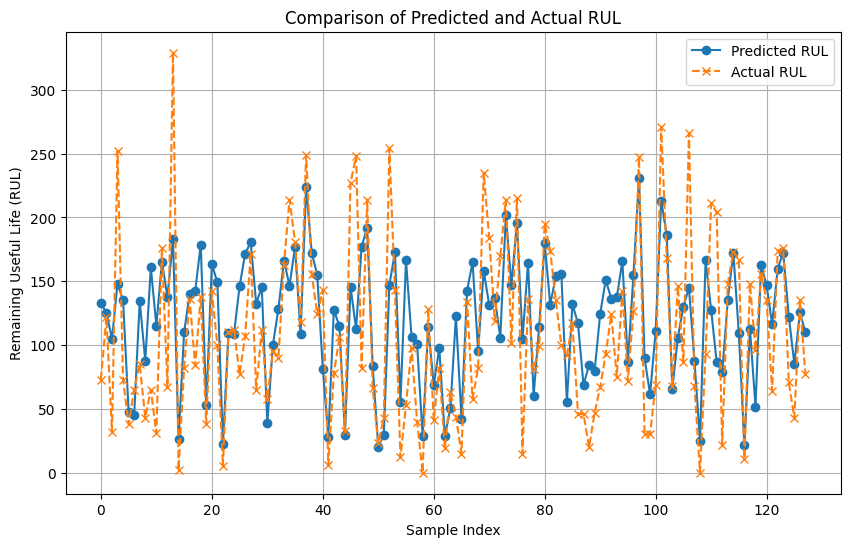

Loss on random batch: 0.008705105632543564


In [76]:
batch_loader = next(iter(validation_loader))

loss, _, _ = predict_on_batch(
    model=centralize_transformer_model,
    batch_loader=batch_loader,
    return_actual_rul=True,
    show_fig=True,
)
print(f'Loss on random batch: {loss}')

# Part II. Explainable Artificial Intelligence for RUL forecasting using Transformer model

### Prediction

In [179]:
# Hàm dự đoán
def predict_single_sample(data_numpy):
    """Dự đoán đầu ra của mô hình cho một mẫu đầu vào."""
    # Đảm bảo dữ liệu có kích thước (batch_size, sequence_length, feature_dim)
    data_tensor = torch.tensor(data_numpy, dtype=torch.float32).to(DEVICE)
    data_tensor = data_tensor.view(data_tensor.shape[0], sequence_length, input_dim)  # Trả về 3D
    centralize_transformer_model.eval()
    with torch.no_grad():
        # Truyền qua mô hình
        predictions = centralize_transformer_model(data_tensor)
    return predictions.cpu().numpy()  # Đầu ra hồi quy (batch_size, 1)

### XAI using SHAP

In [180]:
# Dữ liệu nền và dữ liệu cần giải thích
background_data, _ = next(iter(validation_loader))
background_data_np = background_data.cpu().numpy()  # (batch_size, 1, feature_dim)

# Chuyển đổi dữ liệu nền thành 2D
sequence_length = 1  # Chiều dài chuỗi
feature_dim = background_data_np.shape[-1]  # 21
background_data_2d = background_data_np.reshape(background_data_np.shape[0], -1)  # (batch_size, sequence_length * feature_dim)

# Tóm tắt dữ liệu nền bằng shap.sample
background_sample = shap.sample(background_data_2d, 50)  # Giới hạn 50 mẫu nền để tăng tốc

# Dữ liệu cần giải thích (chuyển đổi 2D tương tự)
data_to_explain = background_data_np[:10]  # Lấy 10 mẫu đầu tiên
data_to_explain_2d = data_to_explain.reshape(data_to_explain.shape[0], -1)  # (10, sequence_length * feature_dim)

In [181]:
# Tạo KernelExplainer
explainer = shap.KernelExplainer(predict_single_sample, background_sample)

# Tính giá trị SHAP
print("Calculating SHAP values...")
shap_values = explainer.shap_values(data_to_explain_2d, nsamples=100)

# Chuyển SHAP values về dạng (num_samples, sequence_length, feature_dim)
shap_values_array = np.array(shap_values).reshape(data_to_explain.shape[0], sequence_length, feature_dim)

# Kiểm tra kích thước
print("Shape of shap_values_array:", shap_values_array.shape)  # (10, 1, 21)
print("Shape of data_to_explain:", data_to_explain.shape)  # (10, 1, 21)

Calculating SHAP values...


  0%|          | 0/10 [00:00<?, ?it/s]

e:\IAD\.venv\Lib\site-packages\shap\explainers\_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
e:\IAD\.venv\Lib\site-packages\shap\explainers\_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
e:\IAD\.venv\Lib\site-packages\shap\explainers\_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(
e:\IAD\.venv\Lib\site-packages\shap\expl

Shape of shap_values_array: (10, 1, 21)
Shape of data_to_explain: (10, 1, 21)


e:\IAD\.venv\Lib\site-packages\shap\explainers\_kernel.py:640: DeprecationWarning: l1_reg='auto' is deprecated and in a future version the behavior will change from a conditional use of AIC to simply a fixed number of top features. Pass l1_reg='num_features(10)' to opt-in to the new default behaviour.
  warnings.warn(


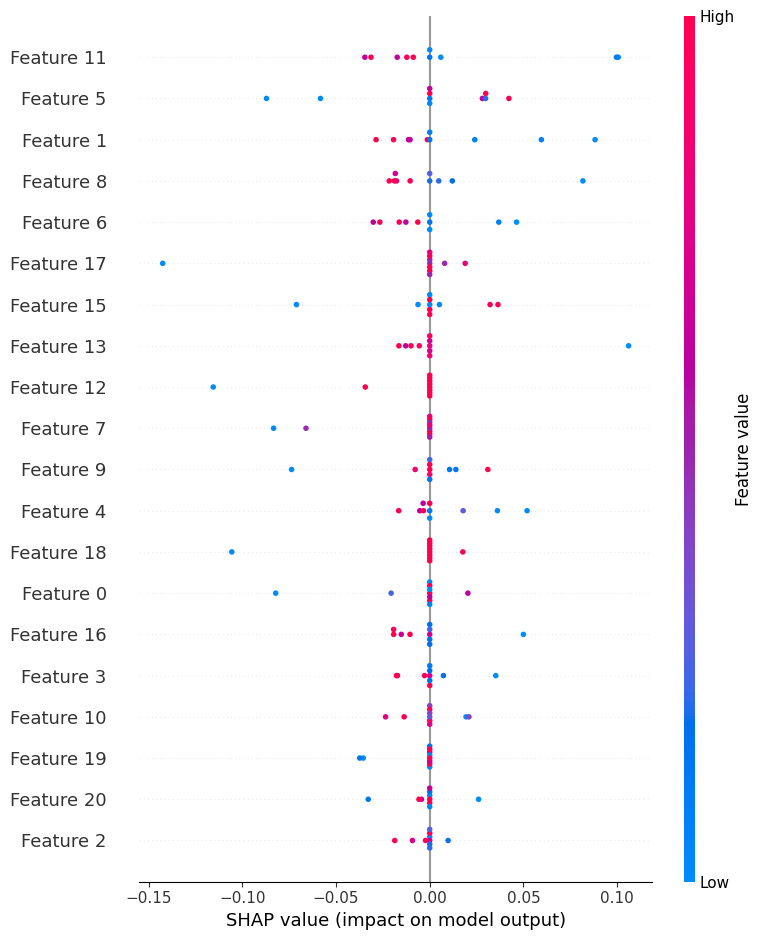

In [183]:
# Vẽ biểu đồ summary (dùng 2D)
data_to_explain_2d = data_to_explain.reshape(data_to_explain.shape[0], -1)
shap_values_2d = shap_values_array.reshape(data_to_explain_2d.shape)
shap.summary_plot(shap_values_2d, data_to_explain_2d)

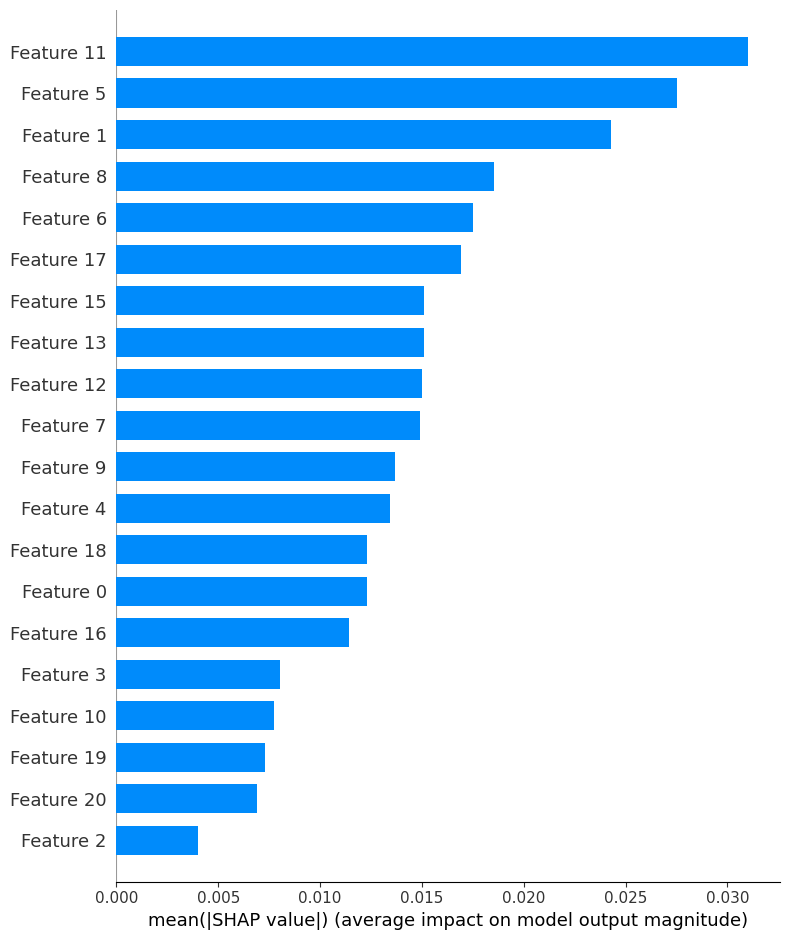

In [184]:
# Vẽ biểu đồ Feature Importance dạng bar chart
shap.summary_plot(shap_values, data_to_explain_2d, plot_type="bar")

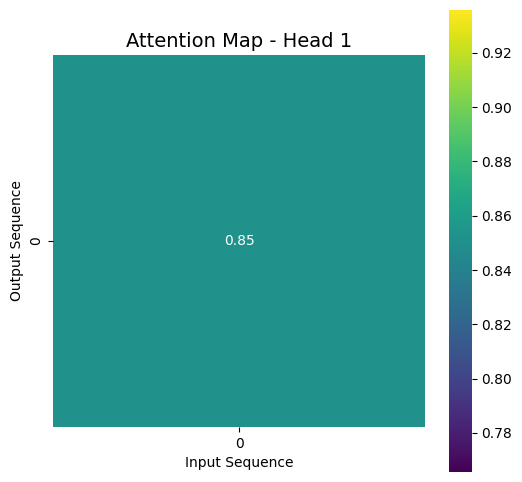

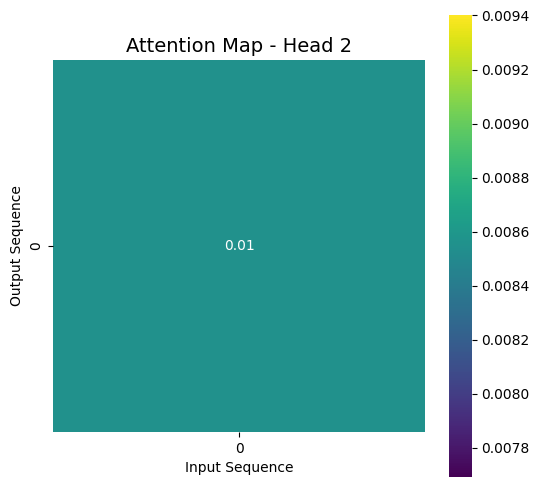

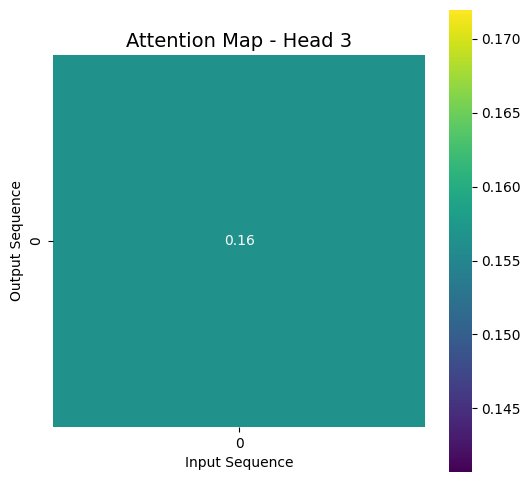

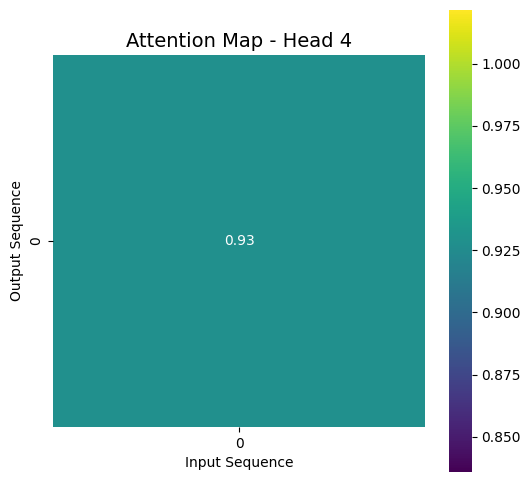

In [186]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Giả sử bạn có các trọng số attention từ mô hình Transformer
# attention_weights: tensor có kích thước (num_heads, seq_len, seq_len)

# Một ví dụ nhỏ với trọng số attention
attention_weights = np.random.rand(4, 1, 1)  # num_heads=4, seq_len=1

# Vẽ attention map
def plot_attention_map(attention_weights, head=0):
    """
    Plot attention map for a given head.
    Args:
        attention_weights: numpy array of shape (num_heads, seq_len, seq_len)
        head: Which attention head to visualize (default=0)
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(
        attention_weights[head],
        annot=True,
        fmt=".2f",
        cmap="viridis",
        cbar=True,
        square=True,
    )
    plt.title(f"Attention Map - Head {head+1}", fontsize=14)
    plt.xlabel("Input Sequence")
    plt.ylabel("Output Sequence")
    plt.show()

# Vẽ attention map cho từng head
for h in range(attention_weights.shape[0]):
    plot_attention_map(attention_weights, head=h)


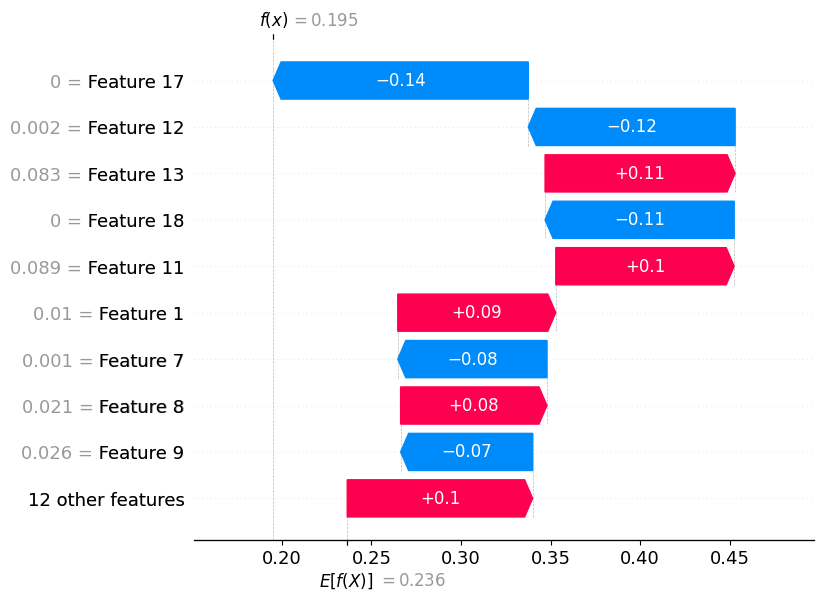

In [189]:
import shap

# Chọn mẫu cần vẽ
sample_idx = 1  # Chỉ số mẫu (thay đổi tùy ý)

# Lấy SHAP values và dữ liệu mẫu
shap_value = shap_values_array[sample_idx]  # Giá trị SHAP cho mẫu (21,)
sample_data = data_to_explain_2d[sample_idx]  # Dữ liệu mẫu (21,)

# Đảm bảo shap_value là 1D
shap_value = shap_value.flatten()

# Vẽ biểu đồ waterfall
shap.waterfall_plot(
    shap.Explanation(
        values=shap_value, 
        base_values=explainer.expected_value, 
        data=sample_data
    )
)


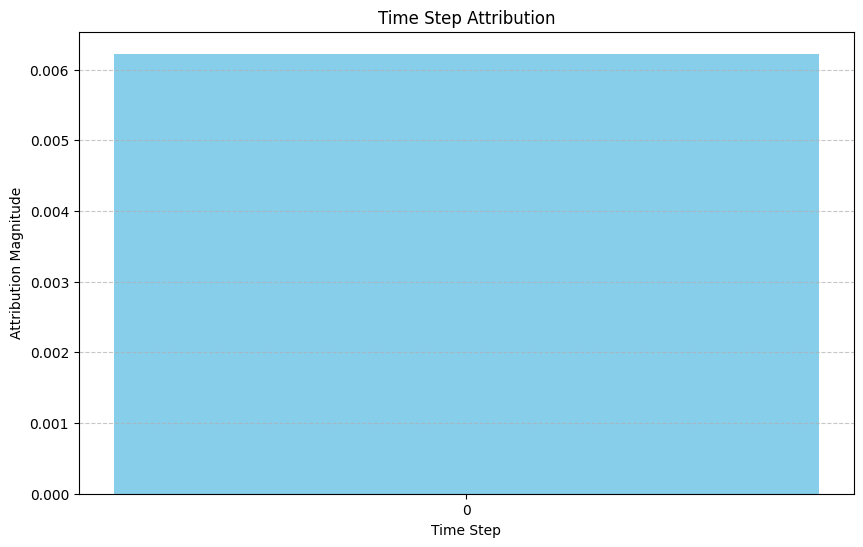

In [192]:
import matplotlib.pyplot as plt
import numpy as np

# Chọn mẫu cần vẽ
sample_idx = 0  # Chỉ số mẫu (thay đổi tùy ý)

# Lấy dữ liệu và SHAP values của mẫu
sample_data = data_to_explain[sample_idx]  # Dữ liệu mẫu (1, sequence_length, num_features)
sequence_length = sequence_length
num_features = feature_dim
sample_shap_values = shap_values_array[sample_idx].reshape(sequence_length, num_features)  # (sequence_length, num_features)

# Tính tổng ảnh hưởng của các đặc trưng tại mỗi time step
time_step_importance = np.abs(sample_shap_values).sum(axis=1)  # Tổng ảnh hưởng mỗi bước thời gian (sequence_length,)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.bar(range(sequence_length), time_step_importance, color="skyblue")
plt.xlabel("Time Step")
plt.ylabel("Attribution Magnitude")
plt.title("Time Step Attribution")
plt.xticks(range(sequence_length))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Part III. Setup Federated Learning with Flower for RUL prediction using Transformer model

### Define parameters for training FL with Flower

In [77]:
num_clients = 10
num_rounds = 50

### Split dataframe to 10 subframe for 10 client

In [34]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

In [35]:
# train.head()
train.shape

(20631, 27)

In [36]:
data = CMAPSSLoaderDataset(train, sequence_length=sequence_length)
train_data, validation_data = train_test_split(data, test_size=0.2, random_state=42)

subset_trains = split_dataset(train_data, num_clients=num_clients)
subset_validations = split_dataset(validation_data, num_clients=num_clients)

client_loader_trains = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_trains]
client_loader_validations = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in subset_validations]

In [37]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 1418 samples
Client 2 will use a subset with 1418 samples
Client 3 will use a subset with 1418 samples
Client 4 will use a subset with 1418 samples
Client 5 will use a subset with 1418 samples
Client 6 will use a subset with 1418 samples
Client 7 will use a subset with 1418 samples
Client 8 will use a subset with 1418 samples
Client 9 will use a subset with 1418 samples
Client 10 will use a subset with 1422 samples


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")

Client 1 will use a subset with 1418 samples
Client 2 will use a subset with 1418 samples
Client 3 will use a subset with 1418 samples
Client 4 will use a subset with 1418 samples
Client 5 will use a subset with 1418 samples
Client 6 will use a subset with 1418 samples
Client 7 will use a subset with 1418 samples
Client 8 will use a subset with 1418 samples
Client 9 will use a subset with 1418 samples
Client 10 will use a subset with 1422 samples


### Update model parameters

In [39]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

### Define the Flower ClientApp

In [52]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train_model(
            model=self.model,
            client_loader_train=self.trainloader,
            client_loader_validation=self.valloader,
            epochs=1,
            learning_rate=learning_rate,
            verbose=False
        )
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test_model(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [53]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(
        input_dim=input_dim,
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers,
        dim_feedforward=dim_feedforward,
        dropout=0.1
    ).to(DEVICE)

    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

### Define the Flower ServerApp

In [54]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [55]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=50)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

### Run the training

In [56]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE.type == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [57]:
try:
    # Run simulation
    run_simulation(
        server_app=server,
        client_app=client,
        num_supernodes=num_clients,
        backend_config=backend_config
    )
except KeyboardInterrupt:
    print("Simulation interrupted by user.")

INFO :      Starting Flower ServerApp, config: num_rounds=50, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=5779) 2024-12-23 11:23:12.312660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=5779) 2024-12-23 11:23:12.346105: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=5779) 2024-12-23 11:23:12.356460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=5779) 2024-12-23 11:23:15.370650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO :      Received 

(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.46163707319647074, Validation Loss: 0.12850052615006766
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.4719871391231815, Validation Loss: 0.16971235970656076
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.4633204735194643, Validation Loss: 0.13589181999365488
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.45475500791023177, Validation Loss: 0.15276245772838593
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.4644324869538347, Validation Loss: 0.12859898805618286
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.476524926101168, Validation Loss: 0.16079536577065787
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.4725697621082266, Validation Loss: 0.1443922221660614
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.46608171953509253, Validation Loss: 0.13852026561896005
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.47574300443132717, Validation Loss: 0.14250738422075906


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.4627751164759199, Validation Loss: 0.1393095925450325


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.08204200180868308, Validation Loss: 0.02918897693355878
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07942754651109378, Validation Loss: 0.02665859709183375
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.0799832446500659, Validation Loss: 0.02544188064833482
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07269612265129884, Validation Loss: 0.02979238952199618
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.0773561146731178, Validation Loss: 0.0287708876033624
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07031968259252608, Validation Loss: 0.029510069638490677
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07689448694388072, Validation Loss: 0.025815922146042187
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07707589212805033, Validation Loss: 0.02455790713429451
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07716541613141696, Validation Loss: 0.027113165706396103


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07542590346808235, Validation Loss: 0.028075003996491432


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.055113067695250116, Validation Loss: 0.041973320146401726
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.08244440456231435, Validation Loss: 0.025715758403142292
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.08403792371973395, Validation Loss: 0.027400356406966846
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.08152008429169655, Validation Loss: 0.026204310978452366
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07925270466754834, Validation Loss: 0.025434120868643124
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07541036636879046, Validation Loss: 0.022493864099184673
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07722401277472575, Validation Loss: 0.026957203323642414
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.057010425720363855, Validation Loss: 0.05732369671265284
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.07900165300816298, Validation Loss: 0.022113260502616566


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.06387039165322979, Validation Loss: 0.024601483717560768


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.0471012427782019, Validation Loss: 0.021865183487534523
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.05011652441074451, Validation Loss: 0.034841044495503105
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.05141694222887357, Validation Loss: 0.019738120958209038
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.05812672805041075, Validation Loss: 0.01769111305475235
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03282775295277437, Validation Loss: 0.025128138562043507
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.05344032340993484, Validation Loss: 0.018258328239123028
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.030833931484570105, Validation Loss: 0.019566834593812626
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.061884284329911075, Validation Loss: 0.022176298623283703
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.05825070602198442, Validation Loss: 0.019690268362561863


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.05406787836303314, Validation Loss: 0.022104687988758087


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.04278419834251205, Validation Loss: 0.021270936354994774
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03942497416088978, Validation Loss: 0.019235916435718536
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03191121139874061, Validation Loss: 0.014022087367872397
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.0410249928633372, Validation Loss: 0.02117270790040493
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.04374378834230205, Validation Loss: 0.01578949484974146
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.029138188809156418, Validation Loss: 0.019474420696496964
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.04235722270095721, Validation Loss: 0.01750802497069041
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.027756976429373026, Validation Loss: 0.012622584899266561
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.037513427436351776, Validation Loss: 0.02688644267618656


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.040347602761661015, Validation Loss: 0.01308133111645778


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.031263142358511686, Validation Loss: 0.027752135569850605
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.028179180497924488, Validation Loss: 0.014100152378280958
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03299468041708072, Validation Loss: 0.018368175874153774
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03653987916186452, Validation Loss: 0.017809519544243813
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.035355466806019344, Validation Loss: 0.015858699567615986
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03596975980326533, Validation Loss: 0.017358475054303806
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03281722384660194, Validation Loss: 0.02490154467523098
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03140842720555762, Validation Loss: 0.02560207744439443
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.029037702595815063, Validation Loss: 0.027792078753312428


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03363710315898061, Validation Loss: 0.018767501537998516


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.026087708538398147, Validation Loss: 0.0170865294833978
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.028990574646741152, Validation Loss: 0.02542695961892605
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.030302223516628146, Validation Loss: 0.013455452087024847
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02567226781199376, Validation Loss: 0.020596986015637715
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02765182980025808, Validation Loss: 0.016939778501788776
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.025780673138797283, Validation Loss: 0.014130789786577225
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.026607278424004715, Validation Loss: 0.015112523299952349
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.029388602823019028, Validation Loss: 0.015507146716117859
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.03348932135850191, Validation Loss: 0.02097284359236558


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.029345505094776552, Validation Loss: 0.019671254480878513


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.023798234527930617, Validation Loss: 0.01513190691669782
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.029070195897171896, Validation Loss: 0.02435954411824544
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.025412178443123896, Validation Loss: 0.01925276902814706
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02620287115375201, Validation Loss: 0.01702580600976944
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.028038614041482408, Validation Loss: 0.024936386694510777
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.027079960874592263, Validation Loss: 0.01496988752235969
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.026685945922508836, Validation Loss: 0.014981810003519058
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02428868319839239, Validation Loss: 0.01534720261891683
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02597068902105093, Validation Loss: 0.013383621349930763


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02436785469762981, Validation Loss: 0.013284343605240187


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.023934913915582, Validation Loss: 0.014068054656187693
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02682965233301123, Validation Loss: 0.013041329570114613
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02267850050702691, Validation Loss: 0.014007551595568657
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02553048877355953, Validation Loss: 0.015994986208776634
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02228389874411126, Validation Loss: 0.012723138245443502
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.022032161243259907, Validation Loss: 0.01538005874802669
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02293907416363557, Validation Loss: 0.013518120162189007
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01930473290849477, Validation Loss: 0.01802191510796547
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02315181295853108, Validation Loss: 0.012179116408030191


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.023382167797535658, Validation Loss: 0.012670088559389114


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.025271749046320718, Validation Loss: 0.012536576949059963
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02261471833723287, Validation Loss: 0.016559965908527374
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02237148443236947, Validation Loss: 0.015986808575689793
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.022130175881708663, Validation Loss: 0.015795370563864708
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.019571598231171567, Validation Loss: 0.015516492538154125
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02382354810833931, Validation Loss: 0.012740871869027615
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02100447976651291, Validation Loss: 0.010696999728679657
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.022538977713945012, Validation Loss: 0.014288236697514852
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.021660807232062023, Validation Loss: 0.015273480986555418


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.0198952187007914, Validation Loss: 0.01335439613709847


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.021955866599455476, Validation Loss: 0.01303007702032725
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01942261999162535, Validation Loss: 0.015044291503727436
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.018945788964629173, Validation Loss: 0.016008912896116573
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017300903253878158, Validation Loss: 0.02176883506278197
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.022210840523863833, Validation Loss: 0.011243555073936781
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.021480535467465717, Validation Loss: 0.012021431388954321
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.019529856586207945, Validation Loss: 0.012980065929392973
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.018577672230700653, Validation Loss: 0.012211324336628119
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.02099367502766351, Validation Loss: 0.013359213868776957


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.019826506652558844, Validation Loss: 0.014462079852819443


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016881734210376937, Validation Loss: 0.015481321762005487
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01583365521704157, Validation Loss: 0.017480546919008095
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01770164833093683, Validation Loss: 0.018304613108436268
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01716182326587538, Validation Loss: 0.011963600292801857
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01865844684652984, Validation Loss: 0.01630203736325105
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.020615374358991783, Validation Loss: 0.018444149444500606
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.018932905280962586, Validation Loss: 0.0135557617371281
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017435823023940127, Validation Loss: 0.014331555925309658
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.018356591928750277, Validation Loss: 0.015490912832319736


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.019998056658854086, Validation Loss: 0.011702758415291706


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014919089308629433, Validation Loss: 0.01289935347934564
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017589952253426116, Validation Loss: 0.013666588502625624
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017022043156127136, Validation Loss: 0.012847021222114563
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016787810794388253, Validation Loss: 0.012170720224579176
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.020957676849017542, Validation Loss: 0.012923003795246283
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01739016470188896, Validation Loss: 0.015477315212289492
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01889590620218466, Validation Loss: 0.011851982523997625
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01838556126070519, Validation Loss: 0.019113261873523395
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.019215602815772097, Validation Loss: 0.015508722824354967


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.019874604341263574, Validation Loss: 0.014726219388345877


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016834869825591642, Validation Loss: 0.012094296514987946
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.018307097333793838, Validation Loss: 0.017316799610853195
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01973710465244949, Validation Loss: 0.013287362642586231
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016933424786354106, Validation Loss: 0.012279459896186987
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017014530564968783, Validation Loss: 0.01736147018770377
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016515886954342324, Validation Loss: 0.013836844203372797
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013790133642032743, Validation Loss: 0.01240968176474174
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014149157563224435, Validation Loss: 0.012140773236751556
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014684674562886357, Validation Loss: 0.013184071208039919


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01778497752578308, Validation Loss: 0.010361467488110065


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 15]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017293039010837674, Validation Loss: 0.01196209341287613
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01659867516718805, Validation Loss: 0.012908454984426498
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017668931822602946, Validation Loss: 0.0121353588377436
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01602212223224342, Validation Loss: 0.014508603140711784
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015272841167946657, Validation Loss: 0.011579501132170359
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01812678559993704, Validation Loss: 0.024488339200615883
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01601910082778583, Validation Loss: 0.012919244666894278
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.018589404334003728, Validation Loss: 0.01222988311201334
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.018685686479633052, Validation Loss: 0.012600222292045752


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014388919419919452, Validation Loss: 0.014078302619357904


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 16]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017794968948389094, Validation Loss: 0.013668809706966082
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014608484809286892, Validation Loss: 0.013522693576912085
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016148619276160996, Validation Loss: 0.012359177693724632
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017734453547745943, Validation Loss: 0.013424078623453775
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014815723368277153, Validation Loss: 0.013857629150152206
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016535817257439096, Validation Loss: 0.010810970949629942
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015706023977448542, Validation Loss: 0.01703820253411929
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01596172573044896, Validation Loss: 0.016619968538482983
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014823373096684614, Validation Loss: 0.012791702213386694


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017208107902357977, Validation Loss: 0.011945464337865511


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 17]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016188935454313953, Validation Loss: 0.012727987952530384
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014307878736872226, Validation Loss: 0.01718197266260783
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.019286242856954534, Validation Loss: 0.011280744026104609
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.020639750252788264, Validation Loss: 0.012712273436288038
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014453254407271743, Validation Loss: 0.012043727251390616
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015908600762486458, Validation Loss: 0.010947785650690397
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013172676088288426, Validation Loss: 0.012320353959997496
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.016927435528486967, Validation Loss: 0.01281207116941611
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01593620531881849, Validation Loss: 0.013188378885388374


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013153138027215997, Validation Loss: 0.010975423113753399


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 18]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014679619732002417, Validation Loss: 0.013510383665561676
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015431560187910994, Validation Loss: 0.014762245118618011
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015387339750304818, Validation Loss: 0.01481684980293115
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013683272448057929, Validation Loss: 0.01249959816535314
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014109159354120493, Validation Loss: 0.011270850896835327
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01614597055595368, Validation Loss: 0.01221688495328029
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015715680085122585, Validation Loss: 0.010945291568835577
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014859019701058665, Validation Loss: 0.011820166682203611
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.018885720055550337, Validation Loss: 0.016395282310744125


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015323770232498646, Validation Loss: 0.013211495553453764


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 19]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013413991352232793, Validation Loss: 0.01228891871869564
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012924701363469163, Validation Loss: 0.009836512617766857
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014183346026887497, Validation Loss: 0.012887146944801012
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012658007365340987, Validation Loss: 0.010289349282781282
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013428736167649427, Validation Loss: 0.01567775383591652
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01502903294749558, Validation Loss: 0.011767113581299782
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014757475815713406, Validation Loss: 0.01209483885516723
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014238012760567168, Validation Loss: 0.0112421956534187
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015301301454504332, Validation Loss: 0.01485542735705773


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013688724643240372, Validation Loss: 0.011886878870427608


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 20]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014625330222770572, Validation Loss: 0.013309220783412457
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014998831902630627, Validation Loss: 0.011373722615341345
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013729840245408317, Validation Loss: 0.01174341949323813
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013360570728157958, Validation Loss: 0.014043474259475866
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015062868672733506, Validation Loss: 0.014793774113059044
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01597549021244049, Validation Loss: 0.012075215888520082
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013571194605901837, Validation Loss: 0.011345495159427324
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.0158606325276196, Validation Loss: 0.011945650912821293
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01346209249459207, Validation Loss: 0.012178644227484861


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.017640345186615985, Validation Loss: 0.012409180402755737


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 21]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013095096956628064, Validation Loss: 0.012670268615086874
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012329388177022338, Validation Loss: 0.010472592587272326
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013409059339513382, Validation Loss: 0.011643307593961557
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014139552523071567, Validation Loss: 0.010558501506845156
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012573841648797194, Validation Loss: 0.013209373690187931
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013500426430255175, Validation Loss: 0.013805507061382135
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014230060779179135, Validation Loss: 0.01704445295035839
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013772245574121674, Validation Loss: 0.012501771872242292
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015193451273565492, Validation Loss: 0.012948431385060152


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015625124409173925, Validation Loss: 0.012393192077676455


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 22]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015627446041132014, Validation Loss: 0.013199740089476109
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010918257641606033, Validation Loss: 0.01170935109257698
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012476999079808593, Validation Loss: 0.014032493034998575
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014739313046447933, Validation Loss: 0.010524042726804813
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013684944249689579, Validation Loss: 0.011974674028654894
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01532445615157485, Validation Loss: 0.011903831424812475
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01657174644060433, Validation Loss: 0.01209260399142901
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01413246818507711, Validation Loss: 0.011957789150377115
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012751845856352398, Validation Loss: 0.011158672161400318


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013426821601266662, Validation Loss: 0.013560194211701551


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 23]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01283949442828695, Validation Loss: 0.011764995753765106
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013491046343309184, Validation Loss: 0.012497505793968836
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01424794077562789, Validation Loss: 0.01008872656772534
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012878185215716561, Validation Loss: 0.013477970225115618
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01176600030157715, Validation Loss: 0.01015871095781525
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011547563985611001, Validation Loss: 0.010800183440248171
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.0140606005055209, Validation Loss: 0.011925532793005308
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01253983190205569, Validation Loss: 0.010323495604097843
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014367412426508963, Validation Loss: 0.014339392383893331


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013255232479423285, Validation Loss: 0.011964941086868445


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 24]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011636910067560772, Validation Loss: 0.014528268948197365
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01380328965994219, Validation Loss: 0.012484796345233917
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014666739540795485, Validation Loss: 0.013907653279602528
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014500381580243507, Validation Loss: 0.01253705316533645
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01521860295906663, Validation Loss: 0.012729888781905174
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012670931328708926, Validation Loss: 0.010911281531055769
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012464778032153845, Validation Loss: 0.010317549109458923
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014373753685504198, Validation Loss: 0.013278503902256489
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014026950113475323, Validation Loss: 0.010932395545144876


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012329424420992533, Validation Loss: 0.010006292878339687


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 25]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013153197554250559, Validation Loss: 0.013559016088644663
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013440065008277694, Validation Loss: 0.014322408164540926
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014233250869438052, Validation Loss: 0.010479819340010485
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012689612495402494, Validation Loss: 0.014774855536719164
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011730066461799046, Validation Loss: 0.012112914584577084
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013177861420748135, Validation Loss: 0.013641379463175932
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014707438259695968, Validation Loss: 0.010285558799902597
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012749447409684459, Validation Loss: 0.009803305690487226
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013651349969829122, Validation Loss: 0.011380891626079878


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013265428598970175, Validation Loss: 0.010878530330955982


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 26]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012669613546070954, Validation Loss: 0.011636092637976011
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014599870812768737, Validation Loss: 0.010740574138859907
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013116466735179225, Validation Loss: 0.01137127603093783
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014854697976261377, Validation Loss: 0.010652349330484867
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011691429380637905, Validation Loss: 0.013610545545816422
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012528032064437866, Validation Loss: 0.01256386780490478
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014218901206428805, Validation Loss: 0.01320333406329155
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011857191294742128, Validation Loss: 0.019152473658323288
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013356980945294103, Validation Loss: 0.014644521909455458


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013853199236715833, Validation Loss: 0.011841260828077793


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 27]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011604152775059143, Validation Loss: 0.011255681825180849
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014858193152273694, Validation Loss: 0.012358636284867922
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01235919282771647, Validation Loss: 0.01184358603010575
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014031447547798356, Validation Loss: 0.011229573128124079
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012891697697341442, Validation Loss: 0.011951756353179613
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011663459551831087, Validation Loss: 0.013533295753101507
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015590661748622855, Validation Loss: 0.01455942044655482
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013674634916242212, Validation Loss: 0.010082824466129145
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013238710855754713, Validation Loss: 0.010299618355929852


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012324196053668857, Validation Loss: 0.012596809615691503


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 28]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012248286666969458, Validation Loss: 0.013488341122865677
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012989381464043012, Validation Loss: 0.012526827864348888
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013151395910729965, Validation Loss: 0.009726698199907938
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.015180572013681134, Validation Loss: 0.013999156964321932
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01141801200962315, Validation Loss: 0.009990335442125797
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013362237873176733, Validation Loss: 0.012413590836028257
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012743178056553006, Validation Loss: 0.016045227957268555
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012713631304601828, Validation Loss: 0.012729157693684101
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012155419137949744, Validation Loss: 0.011801189432541529


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011541448766365647, Validation Loss: 0.010294739777843157


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 29]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012175099613765875, Validation Loss: 0.014515588991343975
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014041208351651827, Validation Loss: 0.012047791543106237
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013065177947282791, Validation Loss: 0.01535387709736824
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013358604240541657, Validation Loss: 0.011271147057414055
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010632414099139472, Validation Loss: 0.010842725324134031
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012213392416015267, Validation Loss: 0.013667024361590544
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013066632207483053, Validation Loss: 0.009707723123331865
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01282184353719155, Validation Loss: 0.011139371742804846
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011350398495172461, Validation Loss: 0.009769887663424015


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013159659846375385, Validation Loss: 0.01282611240943273


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 30]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013573478441685438, Validation Loss: 0.01247373130172491
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014933056120450297, Validation Loss: 0.013427592193086943
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012924601168682178, Validation Loss: 0.01139498253663381
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010317100017952422, Validation Loss: 0.009807676076889038
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012964082260926565, Validation Loss: 0.010794396822651228
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01360568318826457, Validation Loss: 0.011908269176880518
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012471238849684596, Validation Loss: 0.014292054809629917
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013952956845362982, Validation Loss: 0.012885169126093388
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01375059993006289, Validation Loss: 0.009764385720094046


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010788624873384833, Validation Loss: 0.014227117411792278


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 31]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011791737323316434, Validation Loss: 0.012029494779805342
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013169730082154274, Validation Loss: 0.01258027988175551
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012371071536714831, Validation Loss: 0.011311322761078676
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013709201167027155, Validation Loss: 0.0104583241045475
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011573546643679341, Validation Loss: 0.01132606683919827
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01062879478558898, Validation Loss: 0.010421235114336014
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014533982068921128, Validation Loss: 0.011613486334681511
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012736490151534477, Validation Loss: 0.01152111403644085
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012225704810892543, Validation Loss: 0.012705092939237753


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01412522808338205, Validation Loss: 0.009515254758298397


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 32]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011720066967730721, Validation Loss: 0.011371285965045294
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011108955601230264, Validation Loss: 0.014143198728561401
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012958812604968747, Validation Loss: 0.013128187817831835
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013396968599408865, Validation Loss: 0.01025944265226523
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011263458562704423, Validation Loss: 0.011056376931567987
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01197188898610572, Validation Loss: 0.009838279647131761
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012169855724399289, Validation Loss: 0.01081253681331873
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01113265985623002, Validation Loss: 0.009835124636689821
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01222712624197205, Validation Loss: 0.01198260144641002


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012023321003653109, Validation Loss: 0.011664270733793577


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 33]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013418510168169936, Validation Loss: 0.011383303130666414
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01262456139860054, Validation Loss: 0.0123812568684419
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013487335992977023, Validation Loss: 0.013512571031848589
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011906648093524078, Validation Loss: 0.010384497232735157
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011497252232705554, Validation Loss: 0.0126689113676548
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011944864255686602, Validation Loss: 0.013142068559924761
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011705536453519017, Validation Loss: 0.009997434914112091
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011516247953598699, Validation Loss: 0.010970400956769785
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012503064237535, Validation Loss: 0.01143413254370292


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012246536207385361, Validation Loss: 0.012020444497466087


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 34]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012283394811674953, Validation Loss: 0.011996379432578882
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013273038086481392, Validation Loss: 0.009989424298206965
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011688825713160137, Validation Loss: 0.010857200560470423
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013398903150421878, Validation Loss: 0.01584659516811371
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010967489060324928, Validation Loss: 0.010947498182455698
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01156334881670773, Validation Loss: 0.011590208858251572
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013722130097448826, Validation Loss: 0.012245851568877697
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012475301433975497, Validation Loss: 0.012304142117500305
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011732888252784809, Validation Loss: 0.010079664178192616


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011273570669194063, Validation Loss: 0.011360909479359785


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 35]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012227598461322486, Validation Loss: 0.012261122465133667
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011208759931226572, Validation Loss: 0.010068290556470553
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01272006092282633, Validation Loss: 0.011852948305507502
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012916766417523226, Validation Loss: 0.012276922973493734
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01294056698679924, Validation Loss: 0.012422900026043257
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012269450429206094, Validation Loss: 0.012064383365213871
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01193598861573264, Validation Loss: 0.01042390801012516
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011527732674342891, Validation Loss: 0.011696471522251764
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011882396414875984, Validation Loss: 0.012324203581859669


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011761349276639521, Validation Loss: 0.011940421536564827


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 36]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010780081172318509, Validation Loss: 0.012573303033908209
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013076277216896415, Validation Loss: 0.012086585474510988
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012511613468329111, Validation Loss: 0.013465709052979946
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01442216228072842, Validation Loss: 0.015433194115757942
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012382075966646275, Validation Loss: 0.01134294643998146
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011847876012325287, Validation Loss: 0.010469927762945494
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011686291662044823, Validation Loss: 0.010476844695707163
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.00991635243796433, Validation Loss: 0.009883391670882702
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012834392099951705, Validation Loss: 0.011881714997192224


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011499754075581828, Validation Loss: 0.012801425841947397


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 37]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013466871343553066, Validation Loss: 0.01292791310697794
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012020214926451445, Validation Loss: 0.01075570285320282
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010913907627885541, Validation Loss: 0.00934801654269298
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011324401091163358, Validation Loss: 0.009921983194847902
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010859468136914074, Validation Loss: 0.010996431733171145
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012223886093124747, Validation Loss: 0.012915861792862415
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012834779374922315, Validation Loss: 0.011538863802949587
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011668262673386684, Validation Loss: 0.011967357558508715
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011676063217843572, Validation Loss: 0.012193495718141397


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013242289268722137, Validation Loss: 0.01039469987154007


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 38]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012180536985397339, Validation Loss: 0.012758024036884308
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013674513281633457, Validation Loss: 0.012339973822236061
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012949832249432802, Validation Loss: 0.018246930092573166
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011586924587997297, Validation Loss: 0.010813630806903044
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010411148890852928, Validation Loss: 0.0120935815696915
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012030156756130358, Validation Loss: 0.011749807745218277
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011388852105786404, Validation Loss: 0.012479738021890322
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012875044563164314, Validation Loss: 0.010907558103402456
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010348638442034522, Validation Loss: 0.009971547250946363


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012016516954948505, Validation Loss: 0.012759301501015822


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 39]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011405141946549216, Validation Loss: 0.011172041607399782
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011967329463611046, Validation Loss: 0.011983718412617842
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012246898918723067, Validation Loss: 0.01627059591313203
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010489091820394, Validation Loss: 0.010550399621327719
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011161768576130271, Validation Loss: 0.01150146716584762
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010770683952917656, Validation Loss: 0.010453198105096817
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011644499065975348, Validation Loss: 0.010917111610372862
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01185928680934012, Validation Loss: 0.010691644002993902
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011739287370194992, Validation Loss: 0.010846457444131374


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013006777502596378, Validation Loss: 0.011153445889552435


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 40]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011543292862673601, Validation Loss: 0.012095403857529163
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011752277069414655, Validation Loss: 0.011109974545737108
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010746911905395487, Validation Loss: 0.00983690625677506
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013081987388432026, Validation Loss: 0.010950736701488495
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013022706611081958, Validation Loss: 0.012487549024323622
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01147038396447897, Validation Loss: 0.01174895434329907
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011593644468424221, Validation Loss: 0.010231530914704004
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011366826792558035, Validation Loss: 0.012493579958875975
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011958303628489375, Validation Loss: 0.010466934802631537


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01226975586420546, Validation Loss: 0.014772675621012846


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 41]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013182494168480238, Validation Loss: 0.013437913420299688
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01286645334524413, Validation Loss: 0.01824816440542539
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011863481796657046, Validation Loss: 0.012809936267634233
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01157160452567041, Validation Loss: 0.011035839716593424
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011769474290000895, Validation Loss: 0.011198641111453375
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011950396078949174, Validation Loss: 0.01176744264860948
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01164704755259057, Validation Loss: 0.010121254871288935
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011623529950156808, Validation Loss: 0.012316461031635603
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.00963938624287645, Validation Loss: 0.010636196471750736


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010241595019275943, Validation Loss: 0.01036978450914224


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 42]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010294209389636913, Validation Loss: 0.011419363630314669
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012213785278921327, Validation Loss: 0.01387035163740317
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012681443166608611, Validation Loss: 0.014084390364587307
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012588867296775183, Validation Loss: 0.011840450577437878
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011129894449065128, Validation Loss: 0.009653791474799315
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010884359556560716, Validation Loss: 0.009966379031538963
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010920962551608682, Validation Loss: 0.011746884944538275
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011620735128720602, Validation Loss: 0.011331231333315372
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012475113073984781, Validation Loss: 0.01087759000559648


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012238002071777979, Validation Loss: 0.012007296085357666


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 43]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011023753167440494, Validation Loss: 0.011137062683701515
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012644650414586067, Validation Loss: 0.01395420078188181
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013393662249048552, Validation Loss: 0.015387607117493948
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01318789906023691, Validation Loss: 0.009905370262761911
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010393808168979982, Validation Loss: 0.010293958398203054
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010100090721001228, Validation Loss: 0.01164897003521522
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011531230295076966, Validation Loss: 0.01078801415860653
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01178197485084335, Validation Loss: 0.011771999609967073
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011539371606583396, Validation Loss: 0.01192119593421618


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01245963767481347, Validation Loss: 0.009982515747348467


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 44]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010404456678467492, Validation Loss: 0.01169582363218069
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012365443864837289, Validation Loss: 0.011641979527970156
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012520117995639643, Validation Loss: 0.012062782732148966
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011709985245640079, Validation Loss: 0.009407834770778814
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011082328079889217, Validation Loss: 0.012524268279472986
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012492127561320862, Validation Loss: 0.01197357289493084
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.00979519080525885, Validation Loss: 0.010438099193076292
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010967715720956525, Validation Loss: 0.00991747590402762
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.009988413269942006, Validation Loss: 0.010113346700867018


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013241887946302692, Validation Loss: 0.011404300418992838


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 45]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01123419163438181, Validation Loss: 0.012772280722856522
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013341013652582964, Validation Loss: 0.011887927539646626
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012104100353705386, Validation Loss: 0.009774401473502317
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010757342291375002, Validation Loss: 0.010074631310999393
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011966995506857833, Validation Loss: 0.01114971407999595
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011667533467213312, Validation Loss: 0.012319541846712431
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01117923459969461, Validation Loss: 0.010179828231533369
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.014512275694869459, Validation Loss: 0.010718112190564474
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010309991581986347, Validation Loss: 0.010582030129929384


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012324246189867457, Validation Loss: 0.012135899315277735


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 46]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01083859906066209, Validation Loss: 0.01169470294068257
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011605097019734481, Validation Loss: 0.012865331334372362
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011104895267635584, Validation Loss: 0.011747528488437334
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.013047274512549242, Validation Loss: 0.010870834502081076
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.00994994347759833, Validation Loss: 0.010759637535860142
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011272155214101076, Validation Loss: 0.011184845119714737
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011609076367070278, Validation Loss: 0.010418589226901531
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012859091473122438, Validation Loss: 0.01169926580041647
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011087011157845458, Validation Loss: 0.009343737736344337


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012089072105785212, Validation Loss: 0.00997884664684534


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 47]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011854859301820397, Validation Loss: 0.01220842512945334
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011657905221606294, Validation Loss: 0.011193777124087015
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010639863166337213, Validation Loss: 0.010179420933127403
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011723090273638567, Validation Loss: 0.01433489037056764
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.009879358112812042, Validation Loss: 0.011125503728787104
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011855346383526921, Validation Loss: 0.011513344322641691
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011676689803910753, Validation Loss: 0.012500513345003128
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.0116857880493626, Validation Loss: 0.010576621939738592
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011773741183181604, Validation Loss: 0.009554862044751644


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011173997540026903, Validation Loss: 0.01100461557507515


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 48]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010876893065869808, Validation Loss: 0.01174014713615179
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01227717699172596, Validation Loss: 0.012729737907648087
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01168234902434051, Validation Loss: 0.010095545711616674
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011002561426721513, Validation Loss: 0.011037687460581461
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.009806069079786539, Validation Loss: 0.009826830588281155
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01165233296342194, Validation Loss: 0.010156250248352686
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011125204929461082, Validation Loss: 0.014448337567349276
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011291093348215023, Validation Loss: 0.011246460179487864
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011969880821804205, Validation Loss: 0.011874140240252018


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01006001296142737, Validation Loss: 0.012181754844884077


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 49]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012494837981648743, Validation Loss: 0.011368322807053724
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012250272634749612, Validation Loss: 0.013409759538869062
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01111147040501237, Validation Loss: 0.011461963566641012
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.009594146977178752, Validation Loss: 0.010080501126746336
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012901279842481017, Validation Loss: 0.010480815855165323
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011436611879616976, Validation Loss: 0.010460834950208664
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012607071897946298, Validation Loss: 0.009732439493139585
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011293465193981925, Validation Loss: 0.012174224791427454
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011529015804020068, Validation Loss: 0.012814805842936039


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011347286946450671, Validation Loss: 0.010544568610688051


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 50]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01086594199296087, Validation Loss: 0.01308303140103817
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011653943142543236, Validation Loss: 0.01288741392393907
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.01291765714995563, Validation Loss: 0.009967253853877386
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.009927080284493664, Validation Loss: 0.00993586735179027
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010085009271278977, Validation Loss: 0.010629631268481413
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010916655359324068, Validation Loss: 0.011273974552750587
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011780359704668323, Validation Loss: 0.012288927411039671
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.010857769016486904, Validation Loss: 0.009694857522845268
(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.012149329374854764, Validation Loss: 0.011611023296912512


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=5779) Epoch 1/1, Train Loss: 0.011707609131311377, Validation Loss: 0.010717505278686682


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 50 round(s) in 5288.91s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.1300109828511874
INFO :      		round 2: 0.027004684756199517
INFO :      		round 3: 0.02320887930691242
INFO :      		round 4: 0.01781433696548144
INFO :      		round 5: 0.01465010189761718
INFO :      		round 6: 0.018251158110797406
INFO :      		round 7: 0.015152408803502718
INFO :      		round 8: 0.01444543960193793
INFO :      		round 9: 0.0135200676197807
INFO :      		round 10: 0.012787974812090397
INFO :      		round 11: 0.012452240474522114
INFO :      		round 12: 0.012808383256196976
INFO :      		round 13: 0.012204876293738683
INFO :      		round 14: 0.012422807204226652
INFO :      		round 15: 0.012123571336269378
INFO :      		round 16: 0.010867847378055255
INFO :      		round 17: 0.010951089269171158
INFO :      		round 18: 0.010915189298490684
INFO :      		r